# Key-Value Attention Mechanism Homework on Keras: Character-level Machine Translation (Many-to-Many, encoder-decoder)

In this homework, you will create an MT model with key-value attention mechnism that coverts names of constituency MP candidates in the 2019 Thai general election from Thai script to Roman(Latin) script. E.g. นิยม-->niyom 

In [155]:
# !wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

import matplotlib as mpl
import matplotlib.font_manager as fm

fm.fontManager.addfont('thsarabunnew-webfont.ttf') # 3.2+
mpl.rc('font', family='TH Sarabun New')

2.10.1


In [156]:
%matplotlib inline
import keras
import numpy as np
import random
np.random.seed(0)

from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.optimizers import Adam
from keras.utils import to_categorical, pad_sequences
from keras.models import load_model, Model
from keras import backend as K

# %matplotlib inline
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
# from tensorflow.keras.layers import RepeatVector, Dense, Activation, Lambda
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras import Model
# from tensorflow.keras.models import load_model
# import tensorflow.keras.backend as K
# import numpy as np

# import random

## Load Dataset
We have generated a toy dataset using names of constituency MP candidates in 2019 Thai General Election from elect.in.th's github(https://github.com/codeforthailand/dataset-election-62-candidates) and tltk (https://pypi.org/project/tltk/) library to convert them into Roman script.

<img src="https://raw.githubusercontent.com/ekapolc/nlp_2019/master/HW8/images/dataset_diagram.png" alt="Drawing" style="width: 500px;"/>


In [157]:
# from google.colab import drive
# drive.mount('/content/drive')

# import shutil
# shutil.copy("/content/drive/MyDrive/FRA 501 IntroNLP&DL/Dataset/mp_name_th_en.csv", "/content/mp_name_th_en.csv")

In [158]:
import csv
with open('data/mp_name_th_en.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    name_th = []
    name_en = []
    for row in readCSV:
        name_th.append(row[0])
        name_en.append(row[1])

In [159]:
for th, en in zip(name_th[:10],name_en[:10]):
    print(th,en)

ไกรสีห์ kraisi
พัชรี phatri
ธีระ thira
วุฒิกร wutthikon
ไสว sawai
สัมภาษณ์  samphat
วศิน wasin
ทินวัฒน์ thinwat
ศักดินัย sakdinai
สุรศักดิ์ surasak


## Task1: Preprocess dataset for Keras
* 2 dictionaries for indexing (1 for input and another for output)
* DON'T FORGET TO INCLUDE special token for padding
* DON'T FORGET TO INCLUDE special token for the end of word symbol (output)
* Be mindful of your pad_sequences "padding" hyperparameter. Choose wisely (post-padding vs pre-padding)

In [160]:
#FILL YOUR CODE HERE

input_chars = list(set(''.join(name_th)))
output_chars = list(set(''.join(name_en)))

data_size, vocab_size = len(name_th), len(input_chars)+1 # 1 for padding
output_size, output_vocab_size = len(name_en), len(output_chars)+ 2 # 1 for padding 1 for end of word

print('data has %d names, %d unique characters in input, %d unique characters in output.' % (data_size, vocab_size, output_vocab_size))
maxlen = len( max(name_th, key=len)) #max input length
print('max input length is', maxlen)

m = data_size

data has 10887 names, 65 unique characters in input, 24 unique characters in output.
max input length is 20


In [161]:
sorted_input_chars = sorted(input_chars)
sorted_output_chars = sorted(output_chars)

sorted_input_chars.insert(0,"<PAD>") #PADDING
sorted_output_chars.insert(0,"<EOS>") #END OF WORD
sorted_output_chars.insert(0,"<PAD>") #PADDING

# Input dictionary
input_char2idx = dict((c, i) for i, c in enumerate(sorted_input_chars))
input_idx2char = dict((i, c) for i, c in enumerate(sorted_input_chars))
# Output dictionary
output_char2idx = dict((c, i) for i, c in enumerate(sorted_output_chars))
output_idx2char = dict((i, c) for i, c in enumerate(sorted_output_chars))

print('input_char_indices', input_idx2char)
print('output_char_indices', output_idx2char)

input_char_indices {0: '<PAD>', 1: ' ', 2: 'ก', 3: 'ข', 4: 'ค', 5: 'ฆ', 6: 'ง', 7: 'จ', 8: 'ฉ', 9: 'ช', 10: 'ซ', 11: 'ฌ', 12: 'ญ', 13: 'ฎ', 14: 'ฏ', 15: 'ฐ', 16: 'ฑ', 17: 'ฒ', 18: 'ณ', 19: 'ด', 20: 'ต', 21: 'ถ', 22: 'ท', 23: 'ธ', 24: 'น', 25: 'บ', 26: 'ป', 27: 'ผ', 28: 'ฝ', 29: 'พ', 30: 'ฟ', 31: 'ภ', 32: 'ม', 33: 'ย', 34: 'ร', 35: 'ล', 36: 'ว', 37: 'ศ', 38: 'ษ', 39: 'ส', 40: 'ห', 41: 'ฬ', 42: 'อ', 43: 'ฮ', 44: 'ะ', 45: 'ั', 46: 'า', 47: 'ำ', 48: 'ิ', 49: 'ี', 50: 'ึ', 51: 'ื', 52: 'ุ', 53: 'ู', 54: 'เ', 55: 'แ', 56: 'โ', 57: 'ใ', 58: 'ไ', 59: '็', 60: '่', 61: '้', 62: '๊', 63: '๋', 64: '์'}
output_char_indices {0: '<PAD>', 1: '<EOS>', 2: '-', 3: 'a', 4: 'b', 5: 'c', 6: 'd', 7: 'e', 8: 'f', 9: 'g', 10: 'h', 11: 'i', 12: 'k', 13: 'l', 14: 'm', 15: 'n', 16: 'o', 17: 'p', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'w', 23: 'y'}


In [162]:
print('samplesize', data_size)
Tx = maxlen
# Ty = len(max(name_en, key=len)) # max output length
Ty = Tx * 2
print('max input length is', Tx)
print('max output length is', Ty)

samplesize 10887
max input length is 20
max output length is 40


In [163]:
# Padding
X = []
for name in name_th:
    temp = []
    for char in name:
        temp.append(input_char2idx[char])
    X.append(temp)

Y = []
for name in name_en:
    temp = []
    for char in name:
        temp.append(output_char2idx[char])
    Y.append(temp)

print(f'Befor padding:')
xs = ''.join([input_idx2char[i] for i in X[0]])
print(f'Sample X: {X[0]} -> {xs}')
ys = ''.join([output_idx2char[i] for i in Y[0]])
print(f'Sample Y: {Y[0]} -> {ys}')

# We choose padding='post' because we want to pad after the sentence
X = pad_sequences(X, maxlen=Tx, padding='post', value=0)
Y = pad_sequences(Y, maxlen=Ty, padding='post', value=0)

print(f'After padding:')
xs = ''.join([input_idx2char[i] for i in X[0]])
print(f'Sample X: {X[0]} -> {xs}')
ys = ''.join([output_idx2char[i] for i in Y[0]]) 
print(f'Sample Y: {Y[0]} -> {ys}')

Befor padding:
Sample X: [58, 2, 34, 39, 49, 40, 64] -> ไกรสีห์
Sample Y: [12, 18, 3, 11, 19, 11] -> kraisi
After padding:
Sample X: [58  2 34 39 49 40 64  0  0  0  0  0  0  0  0  0  0  0  0  0] -> ไกรสีห์<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
Sample Y: [12 18  3 11 19 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0] -> kraisi<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>


In [164]:
# One-hot encoding
X = to_categorical(X, num_classes=vocab_size)
Y = to_categorical(Y, num_classes=output_vocab_size)

X = X.reshape(data_size, Tx, vocab_size)
Y = Y.reshape(data_size, Ty, output_vocab_size)

print(f'X shape: {X.shape}')
print(f'Y shape: {Y.shape}')

X shape: (10887, 20, 65)
Y shape: (10887, 40, 24)


# Attention Mechanism
## Task 2: Code your own (key-value) attention mechnism
* PLEASE READ: you DO NOT have to follow all the details in (Daniluk, et al. 2017). You just need to create a key-value attention mechanism where the "key" part of the mechanism is used for attention score calculation, and the "value" part of the mechanism is used to encode information to create a context vector.  
* Define global variables
* fill code for one_step_attention function
* Hint: use keras.layers.Lambda 
* Hint: you will probably need more hidden dimmensions than what you've seen in the demo


In [165]:
from keras.activations import softmax
from keras.layers import Lambda

def softMaxAxis1(x):
    return softmax(x,axis=1)

In [166]:
#These are global variables (shared layers)
## Fill your code here
## you are allowed to use code in the demo as your template. 

#repeater = ???
#concatenator = ???
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)

#Key-values (Hint)
splitter = Lambda(lambda x:tf.split(x, num_or_size_splits=2,axis=2)) 

#fatten_1 = ???
#fatten_2 = ???
fatten_1 = Dense(1, activation = "tanh")
fatten_2 = Dense(1, activation = "relu")

#activator = ???
activator = Activation(softMaxAxis1, name='attention_score') # We are using a custom softmax(axis = 1) loaded in this notebook
#dotor = ???
dotor = Dot(axes = 1)

In [167]:
def one_step_attention(a, s_prev):

    # #Fill code here
    # #key, value = ???
    # key, value = splitter(a)
    # #concat = ...key...
    # # Repeat the decoder hidden state to concat with encoder hidden states
    # s_prev = repeator(s_prev)
    # concat = concatenator([key, s_prev])
    # # Attention function
    # e = fatten_1(concat)
    # energies = fatten_2(e)
    # # Calculate attention weights
    # alphas = attention_scores = activator(energies)
    # #context = ...value...
    # context = dotor([alphas, value])

    # From Equation in the slides a = h (hidden state)(input), s_prev = s_{t-1} (Previous hidden state)
    # Get Key and Value from a (h) = [key, value]
    [key, value] = splitter(a)

    # Find M and pass it through a tanh layer
    # M is the concatenation of the previous hidden state and the current hidden state
    s_prev = repeator(s_prev)
    concat = concatenator([key, s_prev])
    e = fatten_1(concat)

    # Find energies and pass it through a relu layer
    energies = fatten_2(e)

    # Calculate attention scores through softmax
    attention_scores = activator(energies)

    # Find context vector
    context = dotor([attention_scores, value])
 
    return context, attention_scores , energies # return whatever you need to complete this homework 

## Task3: Create and train your encoder/decoder model here
* HINT: you will probably need more hidden dimmensions than what you've seen in the demo

In [168]:
#FILL CODE HERE :Hint --> heatmap in CNN + GradCAM

# def model(Tx, Ty, n_h, n_s, vocab_size, machine_vocab_size):
#   ...

# def inference_encoder(Tx, Ty, n_h, n_s, vocab_size, machine_vocab_size):
#    X = ....
#    h = ....

#    model = Model(inputs=[X],outputs=h)
#    return model

# def inference_decoder(Tx, Ty, n_h, n_s, vocab_size, machine_vocab_size):
#   s0 = ...
#   c0 = ...
#   h = ...
#   context, attention_scores, energies = one_step_attention(h, s)
#   ...decoder_LSTM_cell...
#   out = output_layer(s)

#   model = Model(inputs=[h,s0,c0],outputs=[out,s,c,atten_score,energies])

#   return model

In [169]:
n_h = 32 #hidden dimensions for encoder 
n_s = 64 #hidden dimensions for decoder
encoder_LSTM =  Bidirectional(LSTM(n_h, return_sequences=True),input_shape=(-1, Tx, n_h*2))
decoder_LSTM_cell = LSTM(n_s, return_state = True) #decoder_LSTM_cell
output_layer = Dense(output_vocab_size, activation="softmax") #softmax output layer

In [170]:
def model(Tx, Ty, n_h, n_s, vocab_size, machine_vocab_size):
    """
    Arguments:
    Tx -- length of the input sequence
    Ty -- length of the output sequence
    n_h -- hidden state size of the Bi-LSTM
    n_s -- hidden state size of the post-attention LSTM
    vocab_size -- size of the input vocab
    output_vocab_size -- size of the output vocab

    Returns:
    model -- Keras model instance
    """
    # Define the input of your model
    X = Input(shape=(Tx, vocab_size))
    # Define hidden state and cell state for decoder_LSTM_Cell
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    
    # Initialize empty list of outputs
    outputs = list()
    
    # Encoder Bi-LSTM
    h = encoder_LSTM(X)
    
    # Iterate for Ty steps
    for t in range(Ty):
        # Perform one step of the attention mechanism to get back the context vector at step t
        context, attention_scores, energies = one_step_attention(h, s)
        
        # Apply the post-attention LSTM cell to the "context" vector.
        s, _, c = decoder_LSTM_cell(context, initial_state=[s, c])
        
        # Apply Dense layer to the hidden state output of the post-attention LSTM
        out = output_layer(s)
        
        # Append "out" to the "outputs" list
        outputs.append(out)
    
    # Create model instance
    model = Model(inputs=[X, s0, c0], outputs=outputs)
    
    return model

In [171]:
def inference_encoder(Tx, Ty, n_h, n_s, vocab_size, machine_vocab_size):
   X =  Input(shape=(Tx, vocab_size))
   h = encoder_LSTM(X)
   model = Model(inputs=[X],outputs=h)
   return model

In [172]:
def inference_decoder(Tx, Ty, n_h, n_s, vocab_size, machine_vocab_size):
    h = Input(shape=(inference_encoder(Tx, Ty, n_h, n_s, vocab_size, machine_vocab_size).output_shape[1], n_h*2))
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    context, attention_scores, energies = one_step_attention(h, s)
    s, _, c = decoder_LSTM_cell(context, initial_state=[s, c])
    out = output_layer(s)
    model = Model(inputs=[h,s0,c0],outputs=[out,s,c,attention_scores,energies])
    return model

In [173]:
#FIT YOUR MODEL HERE

In [174]:
# def model(Tx, Ty, n_h, n_s, vocab_size, machine_vocab_size):
#     # Set up encoder 
#     encoder_input = Input(shape=(Tx, vocab_size))
#     encoderLSTM = Bidirectional(LSTM(n_h, return_sequences=True),input_shape=(-1, Tx, n_h*2))
#     encoder_output, state_h, state_c = encoderLSTM(encoder_input)
    
#     # Define encoder states
#     encoder_states = [state_h, state_c]
    
#     # Set up decoder
#     decoder_input = Input(shape=(Ty, machine_vocab_size))
    
#     # Set up decoder LSTM
#     decoderLSTM = LSTM(n_s, return_state = True) #decoder_LSTM_cell
    
#     for t in range(Ty):
#         # Perform one step of the attention mechanism to get back the context vector at step t
#         context, attention_scores, energies = one_step_attention(encoder_output, decoder_input)
        
#         # Apply the post-attention LSTM cell to the "context" vector.
#         decoder_output, state_h, state_c = decoderLSTM(context, initial_state=encoder_states)
        
#         # Apply Dense layer to the hidden state output of the post-attention LSTM
#         decoder_dense = Dense(machine_vocab_size, activation="softmax")

In [175]:
model = model(Tx, Ty, n_h, n_s, vocab_size, output_vocab_size)

In [176]:
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 20, 65)]     0           []                               
                                                                                                  
 bidirectional_3 (Bidirectional  (None, 20, 64)      25088       ['input_13[0][0]']               
 )                                                                                                
                                                                                                  
 s0 (InputLayer)                [(None, 64)]         0           []                               
                                                                                                  
 lambda_3 (Lambda)              [(None, 20, 32),     0           ['bidirectional_3[0][0]', 

In [177]:
# opt = Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.999, decay=0.01)
opt = Adam(learning_rate=0.1)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

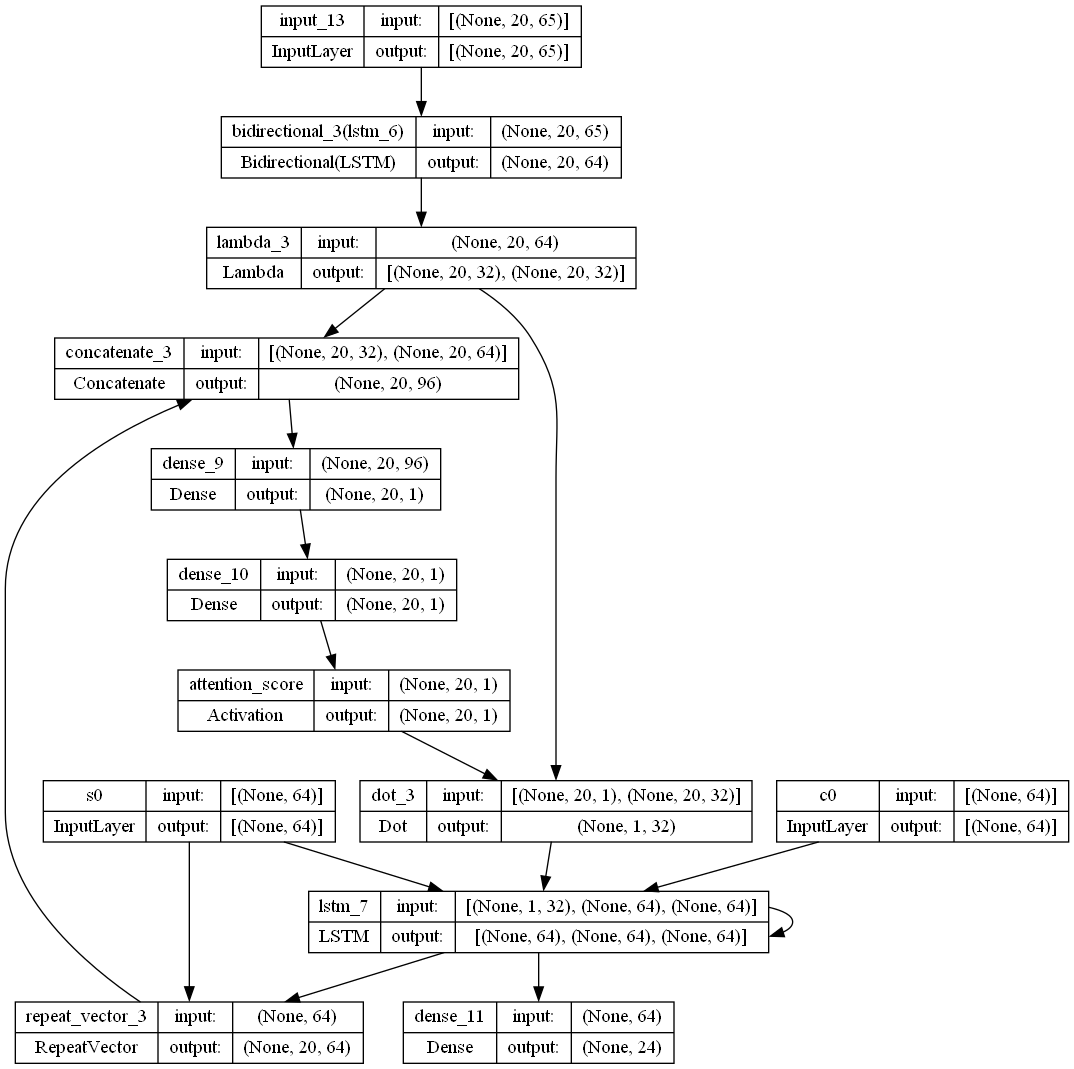

In [178]:
from keras.utils import plot_model

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [179]:
# Initialize s0 and c0
# With m = vocab_size, n_s = 64 hidden dimensions of the decoder
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
# Create a list of outputs
# We need to swap the axis because the model expects the output to be of shape (m, Ty, vocab_size)
outputs = list(Y.swapaxes(0,1))

In [180]:
print(f'Y shape: {Y.shape} and outputs shape: {np.array(outputs).shape}')

Y shape: (10887, 40, 24) and outputs shape: (40, 10887, 24)


In [181]:
# model.fit([X, s0, c0], outputs, epochs=30, batch_size=100, verbose=1)
model.fit([X, s0, c0], outputs, epochs=10, batch_size=300, verbose=1)

Epoch 1/10
37/37 [==============================] - 68s 253ms/step - loss: 39.9034 - dense_11_loss: 3.3529 - dense_11_1_loss: 2.9793 - dense_11_2_loss: 3.5946 - dense_11_3_loss: 3.6154 - dense_11_4_loss: 3.6376 - dense_11_5_loss: 3.2087 - dense_11_6_loss: 2.8078 - dense_11_7_loss: 2.0843 - dense_11_8_loss: 1.4953 - dense_11_9_loss: 1.1538 - dense_11_10_loss: 0.7474 - dense_11_11_loss: 0.7008 - dense_11_12_loss: 0.4718 - dense_11_13_loss: 0.5582 - dense_11_14_loss: 0.3829 - dense_11_15_loss: 0.5161 - dense_11_16_loss: 0.3523 - dense_11_17_loss: 0.5046 - dense_11_18_loss: 0.3310 - dense_11_19_loss: 0.5060 - dense_11_20_loss: 0.3119 - dense_11_21_loss: 0.5120 - dense_11_22_loss: 0.2880 - dense_11_23_loss: 0.5148 - dense_11_24_loss: 0.2568 - dense_11_25_loss: 0.4929 - dense_11_26_loss: 0.2277 - dense_11_27_loss: 0.4357 - dense_11_28_loss: 0.2175 - dense_11_29_loss: 0.4021 - dense_11_30_loss: 0.2234 - dense_11_31_loss: 0.4117 - dense_11_32_loss: 0.2325 - dense_11_33_loss: 0.4360 - dense_11_

In [182]:
# model = load_model('model', custom_objects={'one_step_attention': one_step_attention})

In [183]:
inference_encoder_model = inference_encoder(Tx, Ty, n_h, n_s, vocab_size, output_vocab_size)
inference_decoder_model = inference_decoder(Tx, Ty, n_h, n_s, vocab_size, output_vocab_size)

# Thai-Script to Roman-Script Translation
* Task 4: Test your model on 5 examples of your choice including your name! 
* Task 5: Show your visualization of attention scores on one of your example 

In [184]:
#task 4
#fill your code here
def prep_input(input_list):
    X = []
    for name in input_list:
        temp = []
        for char in name:
            temp.append(input_char2idx[char])
        X.append(temp)
    X = pad_sequences(maxlen=Tx, sequences=X, padding="post", value=0)
    X = to_categorical(X, num_classes=vocab_size)
    X = X.reshape(len(input_list), Tx, vocab_size)
    return X

In [185]:
EXAMPLES_ = ["อธิเมศร์",'สรพัศ',"ธนัช","มิก","ซ้ง","ออมซ์","ไกรสีห์","พัชรี","เบิ้ล","สิรวิชญ์"]
X_ = prep_input(EXAMPLES_)
s0_ = np.zeros((len(EXAMPLES_), n_s))
c0_ = np.zeros((len(EXAMPLES_), n_s))
print(X_.shape)

(10, 20, 65)


In [186]:
pred_ = model.predict([X_, s0_, c0_])
pred_ = np.swapaxes(pred_, 0, 1)
pred_ = np.argmax(pred_, axis=-1)
for j in range(len(pred_)):
    temp = [c for c in pred_[j] if c != 0]
    output_ = ''.join([output_idx2char[i] for i in temp])
    print("input: ", EXAMPLES_[j], "output: ", output_)

1/1 [==============================] - 13s 13s/step
input:  อธิเมศร์ output:  shaaan
input:  สรพัศ output:  phahhan
input:  ธนัช output:  phaaan
input:  มิก output:  nan
input:  ซ้ง output:  san
input:  ออมซ์ output:  na
input:  ไกรสีห์ output:  shaaa
input:  พัชรี output:  phahaa
input:  เบิ้ล output:  san
input:  สิรวิชญ์ output:  sanaaa


### Plot the attention map
* If you need to install thai font: sudo apt install xfonts-thai
* this is what your visualization might look like:
--> https://drive.google.com/file/d/168J5SPSf4NNKj718wWUEDpUbh8QYZKux/view?usp=share_link

In [187]:
# EXAMPLES = ???
# h = inferEncoder_model.predict(EXAMPLES)
# s0 = ???
# c0 = ???
# ...
# Ty = 10
# for t in range(Ty):
#   out,s,c,attention_scores,energies = inferDecoder_model.predict([h,s0,c0])
# ...


In [196]:
EXAMPLES_ = ['อธิเมศร์']
EXAMPLES = prep_input(EXAMPLES_)
print(EXAMPLES.shape)
print(EXAMPLES)

(1, 20, 65)
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]]


In [197]:
h = inference_encoder_model.predict(EXAMPLES)

1/1 [==============================] - 0s 38ms/step


In [198]:
s0 = np.zeros((len(EXAMPLES_), n_s))
c0 = np.zeros((len(EXAMPLES_), n_s))
list_attention = []
list_prediction = []

In [199]:
Ty = 40

In [200]:
for t in range(Ty):
    out,s,c,attention_scores,energies = inference_decoder_model.predict([h,s0,c0])
    s0 = s
    c0 = c
    pred = np.argmax(np.swapaxes(out, 0, 1), axis=0)[0]
    if t < len(EXAMPLES_[0]):
        print(t, ": input -->", EXAMPLES_[0][t], "output -->", output_idx2char[pred], '(',pred,')')
    else:
        print(t, ": input -->", "<PAD>", "output -->", output_idx2char[pred])
    print(attention_scores.reshape(-1))
    list_attention.append(attention_scores.reshape(-1))
    list_prediction.append(output_idx2char[pred])

1/1 [==============================] - 0s 28ms/step
0 : input --> อ output --> s ( 19 )
[0.01573717 0.37913698 0.02395334 0.01573717 0.01573717 0.05264989
 0.28254297 0.01573717 0.01573717 0.01573717 0.01573717 0.01573717
 0.01573717 0.01573717 0.01573717 0.01573717 0.01573717 0.01573717
 0.01573717 0.02565912]
1/1 [==============================] - 0s 31ms/step
1 : input --> ธ output --> h ( 10 )
[0.06087443 0.06133384 0.06132817 0.06115649 0.06120227 0.061331
 0.06133356 0.05865559 0.02584214 0.00864712 0.00218239 0.00176308
 0.04703894 0.06037886 0.06057258 0.06117808 0.06124303 0.06128879
 0.06132114 0.06132851]
1/1 [==============================] - 0s 31ms/step
2 : input --> ิ output --> a ( 3 )
[0.02560269 0.34795293 0.02560269 0.02560269 0.02560269 0.02560269
 0.19119857 0.02560269 0.02560269 0.02560269 0.02560269 0.02560269
 0.02560269 0.02560269 0.02560269 0.02560269 0.02560269 0.02560269
 0.02560269 0.02560269]
1/1 [==============================] - 0s 33ms/step
3 : input --

In [ ]:
#task 5
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family']='TH Sarabun New'  #you can change to other font that works for you
#fill your code here